# Insights

Our in depth research has allowed us to provide insights to clients who want their YouTube videos to trend.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import sent_tokenize, word_tokenize
from IPython.core.display import display, HTML
from skimage import io
from sklearn.cluster import MiniBatchKMeans # mini batch kmeans for performance
from collections import Counter
from numpy.linalg import norm
import urllib.request as request
import json
import warnings

import os
os.sys.path.append(os.path.dirname(os.path.abspath('..')))
from factored.retrieve_data import retrieve_data
from factored.analyse_colour import get_colours, find_most_similar
from factored.recency_model import create_recency_data, feature_engineer

plt.style.use('ggplot')
nltk.download('stopwords')
nltk.download('vader_lexicon')
warnings.simplefilter(action='ignore', category=Warning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ramin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# YouTube videos

Our clients are YouTubers. As such they may be curious about a particular video. We can retrieve this using the YouTube API:

In [3]:
video_id = 'jQOfbObFOCw'

video_data = retrieve_data(video_id)

We will be comparing this instance of a video to our results surrounding the trending videos dataset:

In [4]:
data = pd.read_csv('../../data/data.csv')

## How should I speak to my audience?

The title of a video allows people to search for it. Aside from the thumbnail of the video, it is the only piece of information that tells potential viewers what they will be watching. Therefore, it is important to get the tone right. Speaking to your audience in a misaligned tone can mean the difference between trending and receiving little to no views.

We can evaluate the compound sentiment of a YouTube video title. This tells us how positive or negative the sentiment of the sentence is. Averaging the sentiment over all videos in a single category yields a key insight into the different kinds of audiences.

In [20]:
sentiment_analyser = SentimentIntensityAnalyzer()

In [23]:
def get_sentiment(sentence):
    return sentiment_analyser.polarity_scores(sentence)['compound']

In [24]:
sentiment = data['title'].apply(get_sentiment)

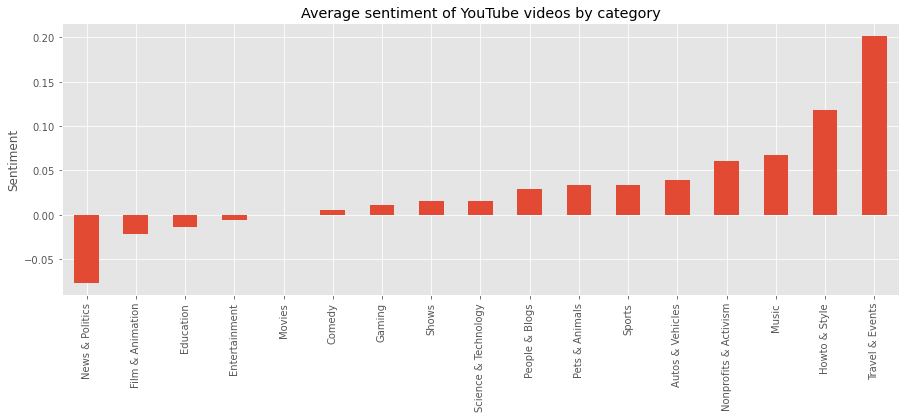

In [25]:
plt.figure(figsize=(15, 5))

sentiment_by_category = pd.concat(
    [data[['category_name','video_id']], sentiment], axis=1
).groupby('video_id').first().groupby('category_name').mean()['title'].sort_values()

sentiment_by_category.plot.bar()

plt.xlabel('')
plt.ylabel('Sentiment')
plt.title('Average sentiment of YouTube videos by category')
plt.show()

Travel & Events video titles are the most positive whereas News & Politics are the most negative. It is clear that audiences of newsworthy and politicial videos are more inclined to click videos which convey negative sentiment, while viewers of travelling channels are more likely to want uplifting and optimistic content. In turn, YouTubers need to learn to cater to these audiences and therefore adjust the perceived sentiment of their titles (and content) accordingly.

We can test whether our client's video title's sentiment falls in the 95th percentile of the category's sentiment distribution. The choice of percentile can be tightened to quantify how closely the video follows this trend.

In [28]:
video_title_sentiment = get_sentiment(video_data['title'])

sentiment_percentile = np.percentile(
    sentiment[data[data['category_id'] == video_data['category_id']].index], [0 + 2.5, 100 - 2.5]
)

print((video_title_sentiment > sentiment_percentile[0]) and (video_title_sentiment < sentiment_percentile[1]))

True


## How long should my title be?

Questions such as how long the title of a video should be or how many tags to use are difficult to answer precisely. However, there is a well established average number which the majority of trending YouTubers seem to favour.

In [32]:
lengths = data['title'].apply(lambda s: len(word_tokenize(s)))

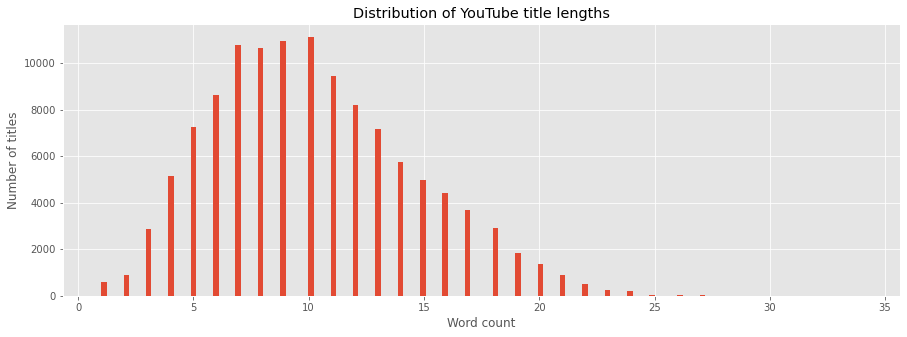

In [33]:
plt.figure(figsize=(15,5))
lengths.hist(bins='auto')
plt.title('Distribution of YouTube title lengths')
plt.xlabel('Word count')
plt.ylabel('Number of titles')
plt.show()

It seems that the modal sentence length amongst trending videos is around $10$ words with significantly longer and shorter titles not trending well. This is likely because it is long enough to convey information while being short enough to be readable. 

In the case of our client, we can test whether the title length falls within the 95th percentile of the distribution:

In [34]:
title_length = len(word_tokenize(video_data['title']))

title_length_percentile = np.percentile(lengths, [0 + 2.5, 100 - 2.5])

print((title_length < title_length_percentile[1]) and (title_length > title_length_percentile[0]))

True


## Do I stand out?

In [35]:
def find_most_similar(hex_colours, n=2):
    rgb_colours = [rgb(i[1:]) for i in hex_colours]
    rgb_colours = [i for j in rgb_colours for i in j]

    RGB_colours = dd.filter(regex='^[rgb]\-[0-9]$',axis=1).values
    
    rgb_colours = np.array([rgb_colours]).T
    
    RGB_dot_rgb = RGB_colours.dot(rgb_colours).T[0]
    norm_RGB_times_norm_rgb = norm(RGB_colours, axis=1) * norm(rgb_colours)
    cosine_similarity = RGB_dot_rgb / norm_RGB_times_norm_rgb
    
    index = cosine_similarity.argsort()[-n:][::-1]
        
    return dd.iloc[index]['thumbnail_link']

YouTube thumbnails are one of the main aspects of a consumer's browsing experience. As such, it is of interest to YouTubers to find videos in the past which had similar thumbnails and to see if they stand out in a crowded market. We crawled thumbnails of trending YouTube videos and used K-means clustering to extract their dominant colours. Then, using cosine similarity, we can find images which are similar to our client's video thumbnail in terms of colour distribution.

First, we computed the dominant colors in our client's thumbnail image:

In [36]:
hex_colours, counts = get_colours(video_id)

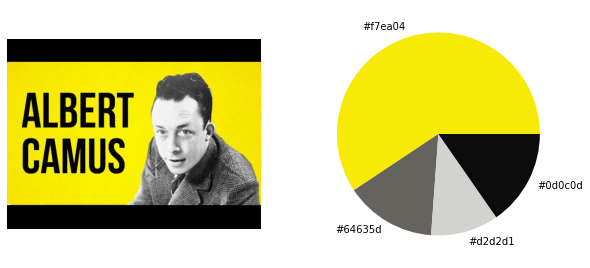

In [37]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].set_axis_off()
ax[0].imshow(io.imread(video_data['thumbnail_link']));
ax[1].pie(counts.values(), labels=hex_colours, colors=hex_colours);

Next, the two trending images with most similarity are computed:

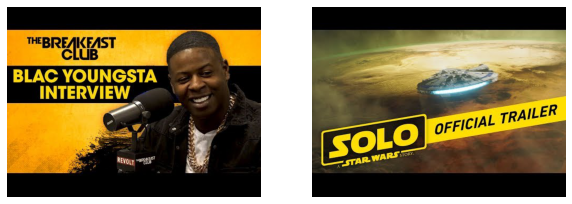

In [17]:
data_colours = pd.read_csv('../../colourdata/colour-output.csv')
images = find_most_similar(data, data_colours, hex_colours, n=2).values

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(io.imread(images[0].replace('default', 'hqdefault')));
ax[1].imshow(io.imread(images[1].replace('default', 'hqdefault')));

The client can generate arbitrarily many such images. This helps them see the quality of trending thumbnails.

## My video is trending. How long will it stay trending?

For YouTubers whose videos have landed on the trending list, the goal is for it to stay there as long as possible. This will maximise exposure and ensure that their video (and corresponding YouTube channel) remains popular.  To aid them in this pursuit, we have built a model that predicts the number of days that a video will spend on YouTube's trending list. 

Since the past determines the future, we considered the average time that videos have trended for in the $5$ days previous to the release of the new video. We also considered the same statistic but restricted to videos in the same category as that of the video of interest. It is also natural to consider the time it has taken for videos in the past to appear on YouTube's trending list as this indicates how viral they were. Other factors including average likes amongst trending videos are also factored in. Lastly, we include statistics on the video itself, such as the number of likes it has.

In [5]:
recency_data = create_recency_data(data, country_code='gb')

In [6]:
engineered_recency_data = feature_engineer(recency_data)

In [7]:
X, y = engineered_recency_data.drop('time_on_trend', axis=1).values, engineered_recency_data[['time_on_trend']].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
rf = RandomForestRegressor()

In [10]:
rf.fit(X_train, y_train)

RandomForestRegressor()

We validate our model and achieve a statistically significant score. This is a vast improvement on only restricting oneself to using statistics on the YouTube video of interest. This is because YouTube is an open marketplace where the behaviours of different trending videos affect each other.

In [11]:
rf.score(X_test, y_test)

0.35098673758525156

Our analysis has a mean absolute error of around 5 days, which contextually is not too bad since many videos live on the trending list for much longer.

In [12]:
mean_absolute_error(y_test, rf.predict(X_test))

5.102933947772657

Since we are dealing with time series data, we employ time series cross validation to get a more accurate representation of the model's performance:

In [13]:
scores = []

tscv = TimeSeriesSplit()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    scores.append(score)

In [14]:
np.mean(scores), np.std(scores)

(0.3100448137607298, 0.05034199646081366)

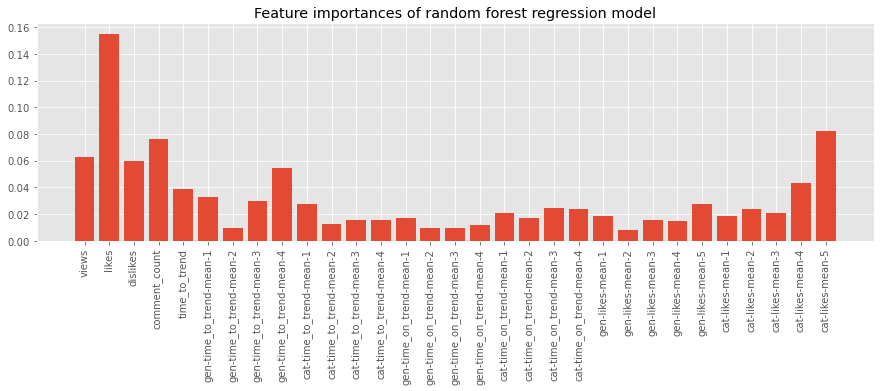

In [15]:
plt.figure(figsize=(15,4))
plt.bar(engineered_recency_data.drop('time_on_trend', axis=1).columns, rf.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances of random forest regression model')
plt.show()

From this, we draw several conclusions:

- The number of likes that a video has when it reaches the trending list contributes the most to how long it will trend for. Practically, this means that YouTubers should try to keep their audience happy. Being controversial is only a viable strategy if there is audience that rewards you for it. Historic likes in the video category are also a good predictor of this.
- The average time that it takes for videos (either in general or in the category of interest) to trend a few days before the video of interest trends plays a great role. Practically, this allows one to time the release of a YouTube video so as to maximise the time spent trending.

It is now straightforward to improve the model by removing features with little importance.

## Will my video trend tomorrow given that it was trending today?

From research, we know that YouTube statistics exhibit long range memory. This means that it should be straightforward to predict whether a video will remain trending tomorrow given that it has trended today. This fact is of great importance to YouTubers whose advertising and video release schedule revolves around the popularity of their videos. If a video is predicted to leave its trending status, a strategy can be preemptively developed moving forwards.

In [16]:
class_recency_data = recency_data.merge(
    recency_data.groupby('video_id').last()['trending_date'].reset_index().rename(columns={'trending_date':'final_date'}), 
    on = 'video_id'
)

In [17]:
class_recency_data['trend_tomorrow'] = class_recency_data['trending_date'] != class_recency_data['final_date']

In [18]:
class_recency_data = feature_engineer(class_recency_data, regression=False)

In [21]:
X, y = class_recency_data.drop('trend_tomorrow', axis=1).values, class_recency_data[['trend_tomorrow']].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [23]:
rf = RandomForestClassifier()

In [24]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
rf.score(X_test, y_test)

0.9228405599180608

The number of misclassified points is:

In [26]:
sum((rf.predict(X_test) ^ y_test)[0])

44

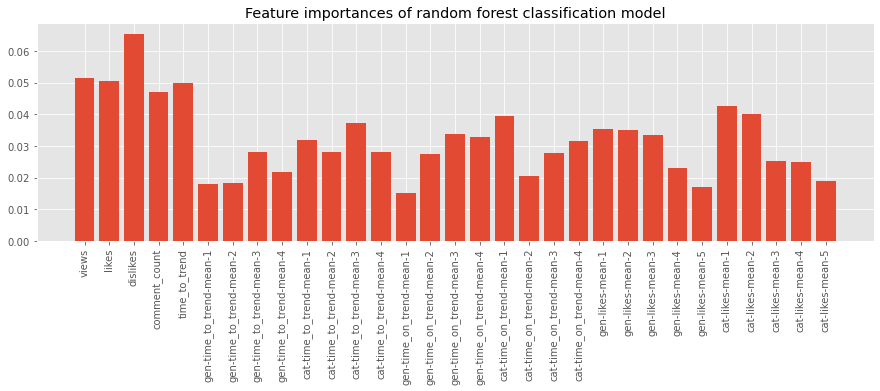

In [28]:
plt.figure(figsize=(15,4))
plt.bar(class_recency_data.drop('trend_tomorrow', axis=1).columns, rf.feature_importances_)
plt.xticks(rotation=90)
plt.title('Feature importances of random forest classification model')
plt.show()

Once again, we carry out time series cross validation:

In [35]:
scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    scores.append(score)

In [36]:
np.mean(scores), np.std(scores)

(0.9261992619926198, 0.00534737149305883)